In [1]:
import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split
from vocabulary import Vocabulary
import tensorflow as tf
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import editdistance
from attention_model import *
import random
import utils
from IPython.display import clear_output
from tqdm import tqdm,trange
import matplotlib.pyplot as plt
%matplotlib inline
import collections

/home/sasha/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def prepare_dictionary():
    dataset = utils.dataset_reader(use_w2v=True)
    tags = utils.read_tags('tags')
    inp_voc = Vocabulary.from_lines(dataset['train'][0] + dataset['test'][0] + dataset['val'][0], use_w2v=True, 
                                    unk='__unknown__')
    out_voc = Vocabulary(['__begin__', '__end__'] + tags, unk=None, use_w2v=False)
    none_idx = out_voc.token_to_idx['none']
    return dataset, tags, inp_voc, out_voc, none_idx

In [3]:
dataset, tags, inp_voc, out_voc, none_idx = prepare_dictionary()

In [4]:
TaggingQuality = collections.namedtuple('TaggingQuality', ['acc', 'f1'])

In [33]:
class supervised_training:
    
    def __init__(self, model, inp_voc, out_voc, none_idx):
        self.inp_voc = inp_voc
        self.out_voc = out_voc
        self.model = model
        self.none_idx = none_idx
        self.class_weights = np.ones(len(out_voc)) * 15.0
        self.class_weights[self.none_idx] = 1.0
        self.class_weights[out_voc.bos_idx] = 1.0
        self.class_weights /= self.class_weights.sum()
        self.input_matrix = tf.placeholder('int32',[None,None])
        self.input_sequence = tf.placeholder('float32', [None, None, inp_voc.w2v_dim])
        self.reference_answers = tf.placeholder('int32',[None,None])
        self.multiplicative_constant = tf.placeholder('float32', [None, None])

        self.logprobs_seq = self.model.symbolic_score(inp_matrix=self.input_matrix, 
                                                      inp=self.input_sequence, 
                                                      out=self.reference_answers)
    
        self.crossentropy = - select_values_over_last_axis(self.logprobs_seq,
                                                           self.reference_answers)
    
        self.mask = infer_mask(self.reference_answers, out_voc.eos_idx)
    
        self.loss = tf.reduce_sum(self.crossentropy*self.mask*self.multiplicative_constant)
        
        self.greedy_translations, self.logp = self.model.symbolic_translate(self.input_sequence, self.input_matrix, 
                                                                            greedy=True)
    
        self.train_step = tf.train.AdamOptimizer().minimize(self.loss)
        initialize_uninitialized(s)
        
    def translate(self, lines):
        """
        You are given a list of input lines. 
        Make your neural network translate them.
        :return: a list of output lines
        """
        # Convert lines to a matrix of indices
        lines_ix, w2v_lines = self.inp_voc.to_matrix(lines)

        # Compute translations in form of indices
        trans_ix = s.run(self.greedy_translations, {self.input_sequence: w2v_lines, self.input_matrix: lines_ix})

        # Convert translations back into strings
        return self.out_voc.to_lines(trans_ix)
    
    
    def sample_batch(self, sentences, labels, batch_size, random=True):
        """
        sample random batch of words and random correct translation for each word
        example usage:
        batch_x,batch_y = sample_batch(train_words, word_to_translations,10)
        """
        sentences = np.array(sentences)
        labels = np.array(labels)
        if random:
            random_idx = np.random.permutation(len(sentences))
        else:
            random_idx = np.arange(len(sentences))
        i = 0 
        while i*batch_size < len(sentences):
            batch_sentences = sentences[random_idx[i*batch_size: (i + 1)*batch_size]].tolist()
            batch_labels = labels[random_idx[i*batch_size: (i + 1)*batch_size]].tolist()
            i += 1
            batch_input, batch_w2v = self.inp_voc.to_matrix(batch_sentences)
            batch_labels, _ = self.out_voc.to_matrix(batch_labels)
            yield batch_input, batch_w2v, batch_labels.astype(np.int32)
            
            
    def score(self, predictions, labels):
        nwords = 0
        ncorrect = 0
        true_positive = 0
        true_negative = 0
        false_positive = 0
        false_negative = 0
        i = 0
        for i, ref_labels in enumerate(labels):
            for j, ref_label in enumerate(ref_labels):
                nwords += 1
                if len(predictions[i]) <= j:
                    out_label = 'none'
                else:
                    out_label = predictions[i][j]
                ncorrect += ref_label == out_label
                if ref_label != 'none' and out_label != 'none':
                    true_positive += 1
                elif ref_label == 'none' and out_label == 'none':
                    true_negative += 1
                elif ref_label == 'none' and out_label != 'none':
                    false_positive += 1
                else:
                    false_negative += 1
        if true_positive == 0 and false_positive == 0:
            precision = 0
        else:
            precision = true_positive/(true_positive + false_positive)
            
        if true_positive == 0 and false_negative == 0:
            recall = 0
        else:
            recall = true_positive/(true_positive + false_negative)
            
        if precision == 0 and recall == 0:
            f_measure = 0
        else:
            f_measure = 2.0*precision*recall/(precision + recall)
        return TaggingQuality(acc=ncorrect / nwords, f1=f_measure)
        
    
    def train_model(self, train_sentences, train_labels, validation_sentences, validation_labels, num_epoch=100):
        loss_history = []
        val_accuracy = []
        val_f1 = []

        for epoch in trange(num_epoch):
            for batch_X, batch_w2v_X, batch_y in self.sample_batch(train_sentences, train_labels, 32):
                
                multiplicative_const = self.class_weights[batch_y]
                
                
                feed_dict = {
                    self.input_sequence: batch_w2v_X,
                    self.input_matrix: batch_X,
                    self.reference_answers: batch_y,
                    self.multiplicative_constant: multiplicative_const
                }

                loss,_ = s.run([self.loss, self.train_step], feed_dict)
                loss_history.append(loss)

            
            # make validation
            current_scores = self.test_model(validation_sentences, validation_labels)
            val_accuracy.append(current_scores.acc)
            val_f1.append(current_scores.f1)
            
            clear_output(True)
            plt.figure(figsize=(12,4))
            plt.subplot(131)
            plt.title('train loss / traning time')
            plt.plot(loss_history)
            plt.grid()
            plt.subplot(132)
            plt.title('val accuracy')
            plt.plot(val_accuracy)
            plt.grid()
            plt.subplot(133)
            plt.title('val f1')
            plt.plot(val_f1)
            plt.grid()
            plt.show()
            print(current_scores)

    def test_model(self, test_words, test_ref):
        predictions = []
        for start_i in trange(0, len(test_words), 32):
            batch_words = test_words[start_i:start_i+32]
            predictions += self.translate(batch_words)
        return self.score(predictions, test_ref)

## Bidirectional LSTM with concat attention

In [34]:
tf.reset_default_graph()
s = tf.InteractiveSession()
model = AttentionTranslationModel('model', inp_voc, out_voc, emb_size=len(out_voc), hid_size=2*len(out_voc), 
                                  mode='concat', rnn_type='LSTM', is_bidir=False)
s.run(tf.global_variables_initializer())
training = supervised_training(model=model, inp_voc=inp_voc, out_voc=out_voc, none_idx=none_idx)

last_decoded Tensor("model/dec/basic_lstm_cell/Mul_5:0", shape=(?, 30), dtype=float32)
<tf.Variable 'model/attention_model/w_att:0' shape=(30, 30) dtype=float32_ref>
pr Tensor("scan/while/attention_model/MatMul:0", shape=(?, 30), dtype=float32)
last_decoded Tensor("model/dec/basic_lstm_cell/Mul_8:0", shape=(?, 30), dtype=float32)
<tf.Variable 'model/attention_model/w_att:0' shape=(30, 30) dtype=float32_ref>
pr Tensor("scan_1/while/attention_model/MatMul:0", shape=(?, 30), dtype=float32)


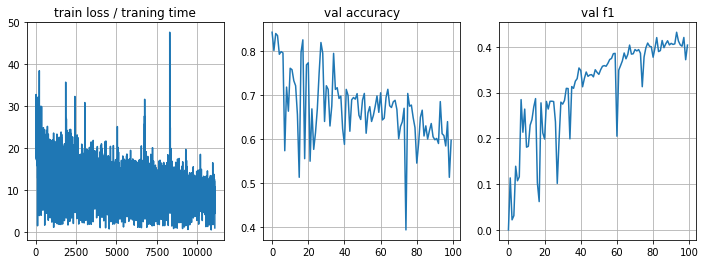

100%|██████████| 100/100 [43:49<00:00, 26.30s/it]

TaggingQuality(acc=0.5972858758407238, f1=0.40375877736472526)


In [35]:
training.train_model(dataset['train'][0], dataset['train'][1], dataset['val'][0], dataset['val'][1])

In [28]:
training.test_model(dataset['test'][0], dataset['test'][1])

100%|██████████| 16/16 [00:01<00:00,  8.15it/s]


TaggingQuality(acc=0.637238200220463, f1=0.4247622599291441)